In [117]:
import numpy as np
import pandas as pd
import seaborn as sns

from constant import data_path, data_dtypes, target_var, all_categorical_cols, all_numerical_cols, categorical_col_feature_values
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from utils import pickle_save, pickle_load

# option to only load pre trained models, and selection of features used for modelling
load_pre_trained = True
save_new_experiment = False

## Data Loader and preprocessing

In [ ]:

df = pd.read_csv(data_path, dtype=data_dtypes).set_index("Name")

X, y = df.drop(target_var, axis=1), df[target_var]

# split the training set and test set with stratify for imbalanced target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# preprocessing on target variable for training and test sets
le = LabelEncoder()
le.fit(y_train)
preprocessed_y_train = le.transform(y_train)
preprocessed_y_test = le.transform(y_test)

# preprocessing on numerical and categorical columns for training and test sets
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical_features_standard_scaler", Pipeline(steps=[("numerical_features_standard_scaler", StandardScaler())]), all_numerical_cols),
        ("ordinal_encoder_with_mapping", Pipeline(steps=[("ordinal_encoder_with_mapping", OrdinalEncoder(categories=categorical_col_feature_values, dtype=int))]), all_categorical_cols)
    ]
)

preprocessed_X_train = X_train.copy()
preprocessed_X_train[all_numerical_cols + all_categorical_cols] = preprocessor.fit_transform(X_train)

preprocessed_X_test = X_test.copy()
preprocessed_X_test[all_numerical_cols + all_categorical_cols] = preprocessor.transform(X_test)

In [ ]:
# starting point of selecting features starts from a shortlist after chi-squared test done in EDA notebook, 
# contains first occurance of the categorical feature groups, and all numerical features
selected_features = ["Alcohol Consumption", "Physical Activity Level", "History of Substance Abuse", "Education Level", "Employment Status", "Income", "Age", "Number of Children"]
# selected_features_kfold = ['Alcohol Consumption', 'Physical Activity Level',
#        'Employment Status', 'Income', 'Number of Children']

if load_pre_trained == False:
    # use select kbest method to find top 5 features
    selector = SelectKBest(score_func=mutual_info_classif, k=5) 
    selector.fit(preprocessed_X_train[selected_features], preprocessed_y_train)
    if save_new_experiment == True:
        pickle_save(file_path="../output/feature_selector.pkl", pickle_obj=selector)
else:
    selector = pickle_load(file_path="../output/feature_selector.pkl")

selected_features_kfold = selector.get_feature_names_out()

## Fitting binary classification models

After all data preprocessing, three models are fitted, with one baseline model (simple model), Logistic Regression and Random Forest classifier. Hyperparameter tuning are done with grid search, based on a selections ranges of parameters, due to limit of training time. It is noted that hyperparameter tunning for RF classifier can take a while. The best models (LR and RF) are saved in `output` folder, as pickle file, it can be easily loaded if required.

In [ ]:
# Baseline dummy model
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(preprocessed_X_train, preprocessed_y_train)

dummy_y_pred = dummy_model.predict(preprocessed_X_test)
print(f"Accuracy: {accuracy_score(preprocessed_y_test, dummy_y_pred)}")
print(f"ROC AUC score: {roc_auc_score(preprocessed_y_test, dummy_y_pred)}")
print(classification_report(preprocessed_y_test, dummy_y_pred, target_names=le.classes_))

Accuracy: 0.6959019100788683
ROC AUC score: 0.5
              precision    recall  f1-score   support

          No       0.70      1.00      0.82     86383
         Yes       0.00      0.00      0.00     37748

    accuracy                           0.70    124131
   macro avg       0.35      0.50      0.41    124131
weighted avg       0.48      0.70      0.57    124131



c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [ ]:
# Hyper parameter tunning on Logistic Regression
lr_param_grid = [    
    {"penalty" : ["l2", None],
    "C" : np.logspace(-4, 4, 10),
    "solver" : ["lbfgs", "newton-cg"],
    "max_iter" : [100, 1000, 3000, 5000]
    }
]

if load_pre_trained == False:
    model = LogisticRegression(class_weight="balanced")

    lr_grid_search = GridSearchCV(model, param_grid=lr_param_grid, cv=3, verbose=True, n_jobs=-1)

    best_lr_model = lr_grid_search.fit(preprocessed_X_train[selected_features_kfold], preprocessed_y_train)
    if save_new_experiment == True:
        pickle_save(file_path="../output/lr_classifier.pkl", pickle_obj=best_lr_model)
else:
    best_lr_model = pickle_load(file_path="../output/lr_classifier.pkl")

y_pred = best_lr_model.best_estimator_.predict(preprocessed_X_test[selected_features_kfold])
print(f"Accuracy: {accuracy_score(preprocessed_y_test, y_pred)}")
print(f"ROC AUC score: {roc_auc_score(preprocessed_y_test, y_pred)}")
print(classification_report(preprocessed_y_test, y_pred, target_names=le.classes_))

Fitting 3 folds for each of 160 candidates, totalling 480 fits
Accuracy: 0.6157124328330554
ROC AUC score: 0.5708856953743726
              precision    recall  f1-score   support

          No       0.74      0.69      0.71     86383
         Yes       0.39      0.46      0.42     37748

    accuracy                           0.62    124131
   macro avg       0.57      0.57      0.57    124131
weighted avg       0.63      0.62      0.62    124131



c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [ ]:

# Hyper parameter tunning on Random Forest Classifier
rf_random_grid = {
    'n_estimators': [100, 1000, 2000],
    'max_features': ["auto", "sqrt"],
    'max_depth': [10, 60, 120],
    'min_samples_split': [1, 10],
    'min_samples_leaf': [1, 10],
    }

if load_pre_trained == False:
    rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)

    rf_grid_search = GridSearchCV(rf_model, param_grid=rf_random_grid, cv=3, verbose=True, n_jobs=-1)

    best_rf_model = rf_grid_search.fit(preprocessed_X_train[selected_features_kfold], preprocessed_y_train)
    if save_new_experiment == True:
        pickle_save(file_path="../output/rf_classifier.pkl", pickle_obj=best_rf_model)
else:
    best_rf_model = pickle_load(file_path="../output/rf_classifier.pkl")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
162 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packag

In [ ]:

y_pred2 = best_rf_model.best_estimator_.predict(preprocessed_X_test[selected_features_kfold])
print(f"Accuracy: {accuracy_score(preprocessed_y_test, y_pred2)}")
print(f"ROC AUC score: {roc_auc_score(preprocessed_y_test, y_pred2)}")
print(classification_report(preprocessed_y_test, y_pred2, target_names=le.classes_))

Accuracy: 0.588467022742103
ROC AUC score: 0.5702746568654683
              precision    recall  f1-score   support

          No       0.75      0.62      0.68     86383
         Yes       0.37      0.52      0.44     37748

    accuracy                           0.59    124131
   macro avg       0.56      0.57      0.56    124131
weighted avg       0.63      0.59      0.60    124131



## Assessing performance of the models

The metrics of the binary classification models are calculated. To compare with different models, metrics listed below will be used:

* Accuracy
* ROC-AUC score
* Precision
* Recall
* F1

In [ ]:
baseline_classifier_performance = classification_report(preprocessed_y_test, dummy_y_pred, target_names=le.classes_, output_dict=True)
baseline_classifier_performance["auc_roc"] = roc_auc_score(preprocessed_y_test, dummy_y_pred)

if load_pre_trained == False:
    lr_classifier_performance = classification_report(preprocessed_y_test, y_pred, target_names=le.classes_, output_dict=True)
    lr_classifier_performance["auc_roc"] = roc_auc_score(preprocessed_y_test, y_pred)

    rf_classifier_performance = classification_report(preprocessed_y_test, y_pred2, target_names=le.classes_, output_dict=True)
    rf_classifier_performance["auc_roc"] = roc_auc_score(preprocessed_y_test, y_pred2)

    if save_new_experiment == True:
        pickle_save(file_path="../output/lr_classifier_performance.pkl", pickle_obj=lr_classifier_performance)
        pickle_save(file_path="../output/rf_classifier_performance.pkl", pickle_obj=rf_classifier_performance)

else:
    lr_classifier_performance = pickle_load(file_path="../output/lr_classifier_performance.pkl")
    rf_classifier_performance = pickle_load(file_path="../output/rf_classifier_performance.pkl")

c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [134]:
overall_metrics = []

for model_name, model_perf in [("baseline", baseline_classifier_performance), ("lr_classifier", lr_classifier_performance), ("rf_classifier", rf_classifier_performance)]:
    for one_metrics in ["auc_roc", "accuracy"]:
        overall_metrics.append((model_name, one_metrics, model_perf[one_metrics]))

overall_metrics = pd.DataFrame.from_records(overall_metrics, columns=["model_name", "metric", "value"])

class_specific_metrics = []
for model_name, model_perf in [("baseline", baseline_classifier_performance), ("lr_classifier", lr_classifier_performance), ("rf_classifier", rf_classifier_performance)]:
    for one_class in ["No", "Yes"]:
        for one_metrics in ["precision", "recall", "f1-score"]:
            class_specific_metrics.append((model_name, one_class, one_metrics, model_perf[one_class][one_metrics]))

class_specific_metrics = pd.DataFrame.from_records(class_specific_metrics, columns=["model_name", "class", "metric", "value"])


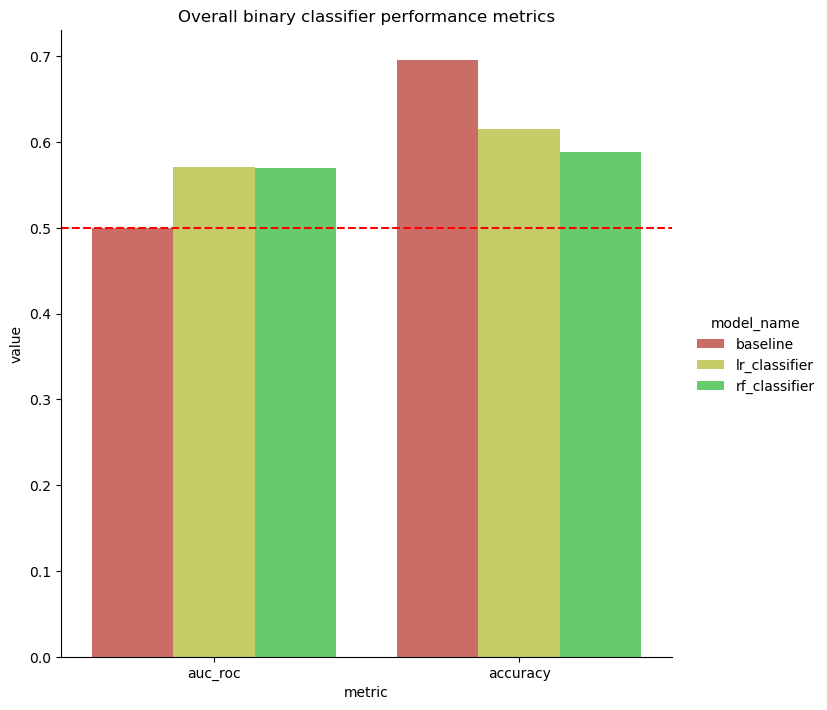

In [180]:
sns.set_palette(palette="hls")
overall_g = sns.catplot(x="metric", y="value", hue="model_name", data=overall_metrics, kind="bar", height=7)
overall_g.refline(y=0.5, color="red").set(title="Overall binary classifier performance metrics")


c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#db5f57'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Yanshan Shi\.conda\envs\axa-depression-classifier\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#db5f57'` for the same effect.

  func(*plot_args, **plot_kwargs)


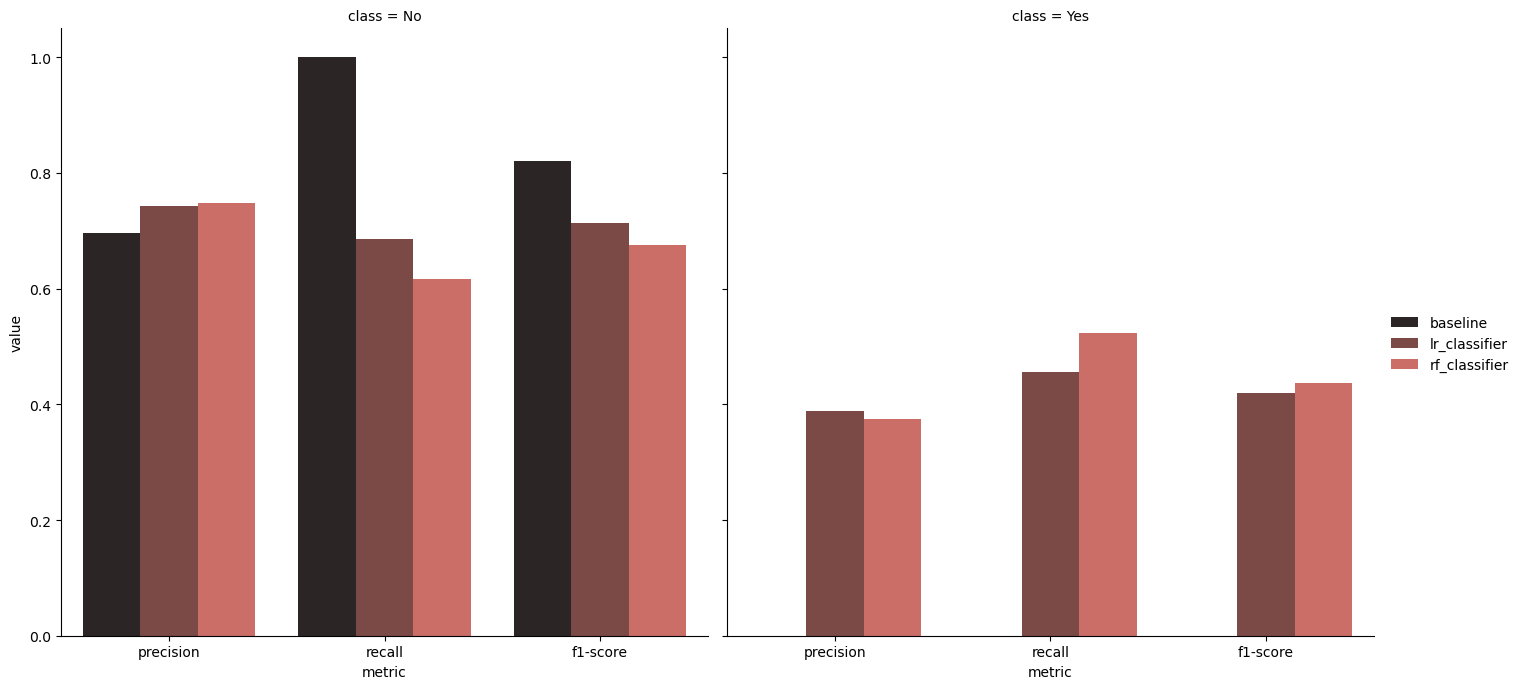

In [183]:
g = sns.FacetGrid(data=class_specific_metrics, col="class", height=7, palette="hls")
g.map_dataframe(sns.barplot, x="metric", y="value", hue="model_name")
g.add_legend()


## Summary
This section containing answers for tech task questions.

### Feature selection
The starting point of selecting features, comes from a conclusion in EDA, to include all numerical columns, and selection of categorical columns (first occurance of the groups which has different distribution from barchats). Then selectKbest algorithm is applied on this short list to generate 5 features include 2 numerical columns and 3 categorical features. The categorical columns are transformed using ordinal encoder and the numerical columns are transformed with standard scaler since `Income` has very different scale compare to the rest.

### Models of choice
3 models are selected, with 1 baseline, a linear model (LR) and a bagging model (RF) for the experiments within this notebook. Hyper parameters are done using gridsearch with cross validation on 3 folds, searching from a selection of parameters grid, limiting them so that the running time is acceptable.

### Assessment on Model performance and discussion on the current best models
Looking at the metric calculated from trained models, it could concluded after hyper parameter tuning, Logistic Regression (LR) and Random Forest (RF) are better than the baseline model. It is the nature that the target variable is imbalanced, and the baseline classifier would condier all predictions as `No` because of this. Overall `accuracy` metrics would be misleading on the actual performance of the model, but `auc-roc score` shows both LR and RF can do slightly better jobs than baseline model.

Looking at class specific metrics graph:
* `No` class: since the baseline is strong, on `No` class, the recall is significantly higher than the other two models. `f1-score` is a balance between recall and precision, and overall the LR and RF cannot beat the baseline model for classify `No` class, even they have slightly better precision compare to the baseline model. 
* `Yes` class: baseline cannot provide any `Yes` prediction, LR and RF has similar precision, and RF has slightly better recall. Overall looking at `f1-score`, RF is slightly better than LR classifier.

Overall, for the current experiment, it is concluded that in terms of performance, RF > LR > baseline. However, it takes longer to do hyper parameter tunning for RF model, LR model can still be good candidate as the performance are similar but it is generally much faster to train.

### Future improvement

The LR and RF model precision and recall is better than baseline, there are still rooms for improvements. Future research on different directions could lead to better performanced model:

* Method for handling imbalanced target: could try undersampling method such as SMOTE, to reduce the size of training set with majority of the class
* New model: boosting classifier (XGBoost, lightGBM etc.), neural networks, etc.
* Feature selection: try new sets of features

